In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./data"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('./data/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('./kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("./kaggle/working/"))

In [ ]:
!rmdir .\kaggle\working\plates\test\cleaned\.DS_Store
#!rmdir ./kaggle/working/plates/test/dirty/.DS_Store

In [24]:
import shutil 
import os
from tqdm import tqdm

data_root = './kaggle/working/plates/'
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 4 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2506.68it/s]


In [65]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomAffine(180, scale=[0.6, 1.5], shear=15),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 2
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

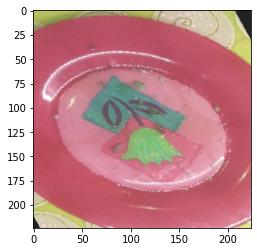

In [66]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

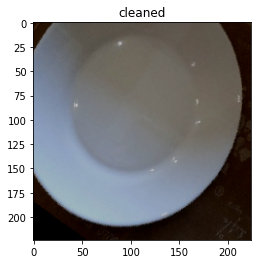

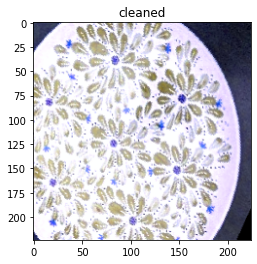

In [67]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [68]:
Path = ''
def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_acc = 0
    best_epoch = 0
    best_val_loss = 1e5
    val_loss = []
    train_loss = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            if phase == 'val':
                val_loss.append(epoch_loss)
                scheduler.step(epoch_loss)
                if epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    if epoch_acc == 1.0 and epoch_loss < best_val_loss:
                        best_val_loss = epoch_loss
                        best_epoch = epoch
                        Path = './models/ef-net_b1_valloss-' + str(epoch_loss) + '.pt'
                        torch.save(model.state_dict(), Path)
            else:
                train_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    print(best_acc, best_val_loss, best_epoch)
    
    return model, train_loss, val_loss

In [69]:
#model = models.resnet101(pretrained=True)
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7')

# Disable grad for all conv layers
# for param in model.parameters():
#     param.requires_grad = False

model._fc = torch.nn.Linear(model._fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)

Loaded pretrained weights for efficientnet-b7


In [70]:
val_loss_history = []
train_loss_history = []
model, train_loss_history, val_loss_history = train_model(model, loss, optimizer, scheduler, num_epochs=200);

Epoch 0/199:


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.89it/s]

train Loss: 0.8592 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.90it/s]

val Loss: 0.8932 Acc: 0.1250
Epoch 1/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.86it/s]

train Loss: 0.8023 Acc: 0.5667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]

val Loss: 0.8027 Acc: 0.6250
Epoch 2/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.6289 Acc: 0.7000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.96it/s]

val Loss: 3.0141 Acc: 0.5000
Epoch 3/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.8238 Acc: 0.4667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.16it/s]

val Loss: 3.8017 Acc: 0.6250
Epoch 4/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.6453 Acc: 0.7000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

val Loss: 4.9120 Acc: 0.6250
Epoch 5/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.7629 Acc: 0.6000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 1.4056 Acc: 0.5000
Epoch 6/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.7626 Acc: 0.3667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.97it/s]

val Loss: 1.1661 Acc: 0.5000
Epoch 7/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.6991 Acc: 0.4667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.6521 Acc: 0.6250
Epoch 8/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.5406 Acc: 0.7667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 1.0115 Acc: 0.5000
Epoch 9/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.7709 Acc: 0.4333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 0.6748 Acc: 0.6250
Epoch 10/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.7468 Acc: 0.4333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.97it/s]

val Loss: 1.5441 Acc: 0.6250
Epoch 11/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.7655 Acc: 0.3667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.17it/s]

val Loss: 1.2768 Acc: 0.6250
Epoch 12/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.6749 Acc: 0.5333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]

val Loss: 5.1343 Acc: 0.5000
Epoch 13/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.6488 Acc: 0.6333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.32it/s]

val Loss: 2.9396 Acc: 0.6250
Epoch 14/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.6586 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.07it/s]

val Loss: 2.9616 Acc: 0.5000
Epoch 15/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.6521 Acc: 0.7000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 1.6128 Acc: 0.5000
Epoch 16/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.02it/s]

train Loss: 0.6152 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.9073 Acc: 0.3750
Epoch 17/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.6302 Acc: 0.6333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.03it/s]

val Loss: 0.7942 Acc: 0.6250
Epoch 18/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.6826 Acc: 0.5667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 4.3303 Acc: 0.5000
Epoch 19/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.02it/s]

train Loss: 0.6694 Acc: 0.5667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.23it/s]

val Loss: 2.4708 Acc: 0.6250
Epoch 20/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.6492 Acc: 0.7333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.35it/s]

val Loss: 9.4145 Acc: 0.5000
Epoch 21/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.5534 Acc: 0.7667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 13.4472 Acc: 0.6250
Epoch 22/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.6206 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s]

val Loss: 3.4302 Acc: 0.7500
Epoch 23/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.4958 Acc: 0.7333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.16it/s]

val Loss: 0.9581 Acc: 0.7500
Epoch 24/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.7008 Acc: 0.5333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.98it/s]

val Loss: 0.5432 Acc: 0.8750
Epoch 25/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.94it/s]

train Loss: 0.7280 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99it/s]

val Loss: 3.2244 Acc: 0.3750
Epoch 26/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.6186 Acc: 0.6333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99it/s]

val Loss: 1.5852 Acc: 0.5000
Epoch 27/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.5950 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.26it/s]

val Loss: 0.8126 Acc: 0.6250
Epoch 28/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.5008 Acc: 0.7667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.86it/s]

val Loss: 0.7501 Acc: 0.8750
Epoch 29/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.5719 Acc: 0.8000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 1.0772 Acc: 0.7500
Epoch 30/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.6751 Acc: 0.5333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.4844 Acc: 0.7500
Epoch 31/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.6073 Acc: 0.7667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99it/s]

val Loss: 0.5228 Acc: 0.7500
Epoch 32/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.89it/s]

train Loss: 0.6912 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

val Loss: 5.5782 Acc: 0.6250
Epoch 33/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.4691 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.07it/s]

val Loss: 8.3383 Acc: 0.5000
Epoch 34/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.6010 Acc: 0.7667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.98it/s]

val Loss: 5.0673 Acc: 0.5000
Epoch 35/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.5048 Acc: 0.7667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 5.8796 Acc: 0.5000
Epoch 36/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.4558 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.97it/s]

val Loss: 1.1831 Acc: 0.7500
Epoch 37/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.6478 Acc: 0.7000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.12it/s]

val Loss: 1.7378 Acc: 0.5000
Epoch 38/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.6896 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 1.9995 Acc: 0.6250
Epoch 39/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.4958 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.7917 Acc: 0.6250
Epoch 40/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.6245 Acc: 0.7333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

val Loss: 0.6813 Acc: 0.5000
Epoch 41/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.5115 Acc: 0.7667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10it/s]

val Loss: 0.8200 Acc: 0.5000
Epoch 42/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.5301 Acc: 0.7000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.93it/s]

val Loss: 0.8455 Acc: 0.5000
Epoch 43/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.6149 Acc: 0.7000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.95it/s]

val Loss: 0.6797 Acc: 0.6250
Epoch 44/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.5299 Acc: 0.7333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.9810 Acc: 0.5000
Epoch 45/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.4411 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.7262 Acc: 0.3750
Epoch 46/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.4010 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.6119 Acc: 0.6250
Epoch 47/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.3821 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.14it/s]

val Loss: 0.5620 Acc: 0.7500
Epoch 48/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.4718 Acc: 0.7667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.7867 Acc: 0.3750
Epoch 49/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.5253 Acc: 0.7667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28it/s]

val Loss: 0.5862 Acc: 0.7500
Epoch 50/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.4992 Acc: 0.8000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.5531 Acc: 0.7500
Epoch 51/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.4422 Acc: 0.7333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.96it/s]

val Loss: 0.5210 Acc: 0.7500
Epoch 52/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.3978 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

val Loss: 0.4330 Acc: 0.7500
Epoch 53/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.3633 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.94it/s]

val Loss: 0.4728 Acc: 0.7500
Epoch 54/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.95it/s]

train Loss: 0.3572 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.03it/s]

val Loss: 0.4696 Acc: 0.7500
Epoch 55/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.3643 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.23it/s]

val Loss: 0.4809 Acc: 0.7500
Epoch 56/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.4888 Acc: 0.7000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.98it/s]

val Loss: 0.4158 Acc: 0.8750
Epoch 57/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.5083 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

val Loss: 0.3851 Acc: 0.8750
Epoch 58/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.4485 Acc: 0.7667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99it/s]

val Loss: 0.4605 Acc: 0.8750
Epoch 59/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.94it/s]

train Loss: 0.4231 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.00it/s]

val Loss: 0.4919 Acc: 0.7500
Epoch 60/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.95it/s]

train Loss: 0.3861 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.97it/s]

val Loss: 0.3778 Acc: 0.8750
Epoch 61/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.2980 Acc: 0.8667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99it/s]

val Loss: 0.4554 Acc: 0.7500
Epoch 62/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.4159 Acc: 0.8667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 0.4538 Acc: 0.7500
Epoch 63/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.2675 Acc: 0.9000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.00it/s]

val Loss: 0.4686 Acc: 0.6250
Epoch 64/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.95it/s]

train Loss: 0.4351 Acc: 0.8000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 0.4998 Acc: 0.7500
Epoch 65/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.6212 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.16it/s]

val Loss: 0.5900 Acc: 0.5000
Epoch 66/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.4043 Acc: 0.8667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]

val Loss: 0.6293 Acc: 0.7500
Epoch 67/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.4608 Acc: 0.8333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.6639 Acc: 0.7500
Epoch 68/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.2701 Acc: 0.8667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10it/s]

val Loss: 0.6912 Acc: 0.7500
Epoch 69/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.3913 Acc: 0.7667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.00it/s]

val Loss: 0.5570 Acc: 0.7500
Epoch 70/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.3002 Acc: 0.9000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.5279 Acc: 0.8750
Epoch 71/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.2164 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.12it/s]

val Loss: 0.4109 Acc: 0.8750
Epoch 72/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.1721 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.4806 Acc: 0.8750
Epoch 73/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.1559 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

val Loss: 0.6862 Acc: 0.7500
Epoch 74/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.3025 Acc: 0.9000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99it/s]

val Loss: 0.5736 Acc: 0.7500
Epoch 75/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.1863 Acc: 0.9000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.98it/s]

val Loss: 0.5738 Acc: 0.7500
Epoch 76/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.95it/s]

train Loss: 0.2172 Acc: 0.8667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.14it/s]

val Loss: 0.6378 Acc: 0.7500
Epoch 77/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.94it/s]

train Loss: 0.3550 Acc: 0.8667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s]

val Loss: 0.6742 Acc: 0.7500
Epoch 78/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.1148 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

val Loss: 0.5676 Acc: 0.7500
Epoch 79/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.2113 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.7679 Acc: 0.7500
Epoch 80/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.91it/s]

train Loss: 0.1683 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.92it/s]

val Loss: 0.6927 Acc: 0.7500
Epoch 81/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.80it/s]

train Loss: 0.1677 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.94it/s]

val Loss: 0.8346 Acc: 0.7500
Epoch 82/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.92it/s]

train Loss: 0.0810 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s]

val Loss: 0.7178 Acc: 0.7500
Epoch 83/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.92it/s]

train Loss: 0.1688 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.13it/s]

val Loss: 0.6371 Acc: 0.7500
Epoch 84/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.1772 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.07it/s]

val Loss: 0.5593 Acc: 0.7500
Epoch 85/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.2421 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10it/s]

val Loss: 0.6660 Acc: 0.7500
Epoch 86/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.1007 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5916 Acc: 0.7500
Epoch 87/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.92it/s]

train Loss: 0.1662 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.16it/s]

val Loss: 0.6175 Acc: 0.7500
Epoch 88/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.1502 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.6255 Acc: 0.7500
Epoch 89/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.0749 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]

val Loss: 0.6170 Acc: 0.7500
Epoch 90/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.1372 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.4825 Acc: 0.7500
Epoch 91/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.1305 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.5261 Acc: 0.7500
Epoch 92/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.1215 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10it/s]

val Loss: 0.6240 Acc: 0.7500
Epoch 93/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.2222 Acc: 0.9000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.96it/s]

val Loss: 0.5543 Acc: 0.7500
Epoch 94/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0572 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 0.4915 Acc: 0.7500
Epoch 95/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.0449 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]

val Loss: 0.5254 Acc: 0.7500
Epoch 96/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0521 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.15it/s]

val Loss: 0.5294 Acc: 0.7500
Epoch 97/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.0650 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5266 Acc: 0.7500
Epoch 98/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0583 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s]

val Loss: 0.5447 Acc: 0.7500
Epoch 99/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0521 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.5220 Acc: 0.7500
Epoch 100/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.1234 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.03it/s]

val Loss: 0.5086 Acc: 0.7500
Epoch 101/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.2313 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.03it/s]

val Loss: 0.6532 Acc: 0.7500
Epoch 102/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.0455 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

val Loss: 0.7610 Acc: 0.7500
Epoch 103/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.95it/s]

train Loss: 0.0296 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.15it/s]

val Loss: 0.7595 Acc: 0.7500
Epoch 104/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0479 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.7476 Acc: 0.7500
Epoch 105/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0511 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.19it/s]

val Loss: 0.7161 Acc: 0.7500
Epoch 106/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0906 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.17it/s]

val Loss: 0.6904 Acc: 0.7500
Epoch 107/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0356 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.12it/s]

val Loss: 0.6958 Acc: 0.7500
Epoch 108/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.1486 Acc: 0.9000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.5542 Acc: 0.7500
Epoch 109/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0393 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80it/s]

val Loss: 0.5203 Acc: 0.7500
Epoch 110/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0301 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.21it/s]

val Loss: 0.5309 Acc: 0.7500
Epoch 111/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0223 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5401 Acc: 0.7500
Epoch 112/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.1680 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.14it/s]

val Loss: 0.5158 Acc: 0.7500
Epoch 113/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0345 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.07it/s]

val Loss: 0.5141 Acc: 0.7500
Epoch 114/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0360 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.23it/s]

val Loss: 0.5206 Acc: 0.7500
Epoch 115/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0950 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.5159 Acc: 0.7500
Epoch 116/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.1564 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.5139 Acc: 0.7500
Epoch 117/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.0262 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s]

val Loss: 0.4921 Acc: 0.7500
Epoch 118/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0928 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.19it/s]

val Loss: 0.4982 Acc: 0.7500
Epoch 119/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.1298 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.14it/s]

val Loss: 0.5119 Acc: 0.7500
Epoch 120/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0392 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99it/s]

val Loss: 0.5016 Acc: 0.7500
Epoch 121/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.1881 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.00it/s]

val Loss: 0.4929 Acc: 0.7500
Epoch 122/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0533 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 0.4898 Acc: 0.7500
Epoch 123/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0291 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.14it/s]

val Loss: 0.4881 Acc: 0.7500
Epoch 124/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.1056 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5101 Acc: 0.7500
Epoch 125/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0436 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.4885 Acc: 0.7500
Epoch 126/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0383 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]

val Loss: 0.4910 Acc: 0.7500
Epoch 127/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.2027 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.90it/s]

val Loss: 0.5026 Acc: 0.7500
Epoch 128/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0363 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.12it/s]

val Loss: 0.4970 Acc: 0.7500
Epoch 129/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0943 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.4774 Acc: 0.7500
Epoch 130/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.1597 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.4721 Acc: 0.7500
Epoch 131/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0846 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.15it/s]

val Loss: 0.4668 Acc: 0.7500
Epoch 132/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0586 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.16it/s]

val Loss: 0.4790 Acc: 0.7500
Epoch 133/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0169 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.25it/s]

val Loss: 0.5138 Acc: 0.7500
Epoch 134/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0905 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.12it/s]

val Loss: 0.5229 Acc: 0.7500
Epoch 135/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0869 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 0.5338 Acc: 0.7500
Epoch 136/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0772 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5440 Acc: 0.7500
Epoch 137/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0378 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.00it/s]

val Loss: 0.5382 Acc: 0.7500
Epoch 138/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0688 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 0.5321 Acc: 0.7500
Epoch 139/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.0462 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]

val Loss: 0.5564 Acc: 0.7500
Epoch 140/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0282 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.5738 Acc: 0.7500
Epoch 141/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0540 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10it/s]

val Loss: 0.5685 Acc: 0.7500
Epoch 142/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.1920 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5658 Acc: 0.7500
Epoch 143/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0771 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5813 Acc: 0.7500
Epoch 144/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0902 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s]

val Loss: 0.5823 Acc: 0.7500
Epoch 145/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.94it/s]

train Loss: 0.1774 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5697 Acc: 0.7500
Epoch 146/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.0576 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.5515 Acc: 0.7500
Epoch 147/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0362 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.13it/s]

val Loss: 0.5305 Acc: 0.7500
Epoch 148/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0288 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5278 Acc: 0.7500
Epoch 149/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.0708 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.12it/s]

val Loss: 0.5324 Acc: 0.7500
Epoch 150/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.1089 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5229 Acc: 0.7500
Epoch 151/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0294 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10it/s]

val Loss: 0.5366 Acc: 0.7500
Epoch 152/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.0949 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.5397 Acc: 0.7500
Epoch 153/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.94it/s]

train Loss: 0.0523 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99it/s]

val Loss: 0.5341 Acc: 0.7500
Epoch 154/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.2513 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.5469 Acc: 0.7500
Epoch 155/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0521 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s]

val Loss: 0.5637 Acc: 0.7500
Epoch 156/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.95it/s]

train Loss: 0.0826 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5785 Acc: 0.7500
Epoch 157/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0338 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.13it/s]

val Loss: 0.5548 Acc: 0.7500
Epoch 158/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0279 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.98it/s]

val Loss: 0.5564 Acc: 0.7500
Epoch 159/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0790 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 0.5594 Acc: 0.7500
Epoch 160/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.1548 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.5517 Acc: 0.7500
Epoch 161/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0434 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10it/s]

val Loss: 0.5634 Acc: 0.7500
Epoch 162/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0789 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.92it/s]

val Loss: 0.5650 Acc: 0.7500
Epoch 163/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0461 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.13it/s]

val Loss: 0.5426 Acc: 0.7500
Epoch 164/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.1177 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 0.5471 Acc: 0.7500
Epoch 165/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0509 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

val Loss: 0.5556 Acc: 0.7500
Epoch 166/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0763 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.5445 Acc: 0.7500
Epoch 167/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0366 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.5261 Acc: 0.7500
Epoch 168/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0431 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.5195 Acc: 0.7500
Epoch 169/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0610 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.5238 Acc: 0.7500
Epoch 170/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.1460 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08it/s]

val Loss: 0.5225 Acc: 0.7500
Epoch 171/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.1701 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.12it/s]

val Loss: 0.5308 Acc: 0.7500
Epoch 172/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0333 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5281 Acc: 0.7500
Epoch 173/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0200 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.5375 Acc: 0.7500
Epoch 174/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0656 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.5570 Acc: 0.7500
Epoch 175/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]

train Loss: 0.0997 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]

val Loss: 0.5219 Acc: 0.7500
Epoch 176/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0602 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]

val Loss: 0.5386 Acc: 0.7500
Epoch 177/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0292 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.15it/s]

val Loss: 0.5320 Acc: 0.7500
Epoch 178/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0802 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.92it/s]

val Loss: 0.5368 Acc: 0.7500
Epoch 179/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0387 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5327 Acc: 0.7500
Epoch 180/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.2245 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.5434 Acc: 0.7500
Epoch 181/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0308 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.94it/s]

val Loss: 0.5449 Acc: 0.7500
Epoch 182/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.95it/s]

train Loss: 0.1164 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

val Loss: 0.5506 Acc: 0.7500
Epoch 183/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.1840 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.91it/s]

val Loss: 0.5548 Acc: 0.7500
Epoch 184/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.1330 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]

val Loss: 0.5370 Acc: 0.7500
Epoch 185/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0827 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.5465 Acc: 0.7500
Epoch 186/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.3097 Acc: 0.8667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.5486 Acc: 0.7500
Epoch 187/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0498 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s]

val Loss: 0.5762 Acc: 0.7500
Epoch 188/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.1104 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]

val Loss: 0.5588 Acc: 0.7500
Epoch 189/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0620 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.07it/s]

val Loss: 0.5573 Acc: 0.7500
Epoch 190/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]

train Loss: 0.0384 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.86it/s]

val Loss: 0.5382 Acc: 0.7500
Epoch 191/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0894 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.5364 Acc: 0.7500
Epoch 192/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0954 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

val Loss: 0.5394 Acc: 0.7500
Epoch 193/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.2343 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.5732 Acc: 0.7500
Epoch 194/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]

train Loss: 0.0295 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s]

val Loss: 0.5646 Acc: 0.7500
Epoch 195/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]

train Loss: 0.0643 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.07it/s]

val Loss: 0.5525 Acc: 0.7500
Epoch 196/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0302 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

val Loss: 0.5681 Acc: 0.7500
Epoch 197/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.0687 Acc: 0.9667



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]

val Loss: 0.5804 Acc: 0.7500
Epoch 198/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]

train Loss: 0.1564 Acc: 0.9333



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06it/s]

val Loss: 0.5650 Acc: 0.7500
Epoch 199/199:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.98it/s]

train Loss: 0.0369 Acc: 1.0000



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.12it/s]

val Loss: 0.5671 Acc: 0.7500
tensor(0.8750, device='cuda:0') 100000.0 0


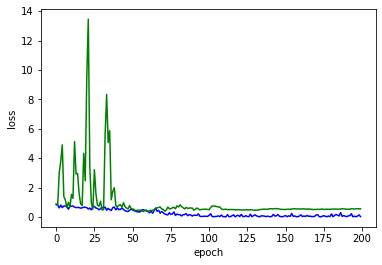

In [71]:
import matplotlib.pyplot as plt
plt.plot(train_loss_history, color="blue")
plt.plot(val_loss_history, color="green")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [46]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'test\\unknown'

In [47]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('./test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [48]:
#model.load_state_dict(torch.load(Path))
model.load_state_dict(torch.load('./models/ef-net_b1_valloss-0.06274628220126033.pt'))

model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|████████████████████████████████████████████████████████████████████████████████| 372/372 [00:09<00:00, 41.14it/s]


In [49]:
import ntpath
ntpath.basename("a/b/c")

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

file_names = [path_leaf(os.path.splitext(path)[0]) for path in test_img_paths]

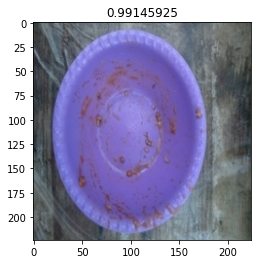

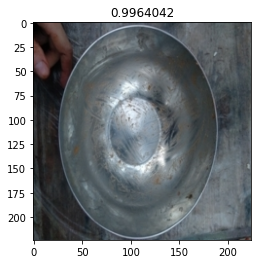

In [50]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [52]:
import pandas as pd
submission_df = pd.DataFrame.from_dict({'id': file_names, 'label': test_predictions})

In [53]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('./kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

<ipython-input-53-8635b8c2fe36>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('./kaggle/working/test/unknown/', '')
<ipython-input-53-8635b8c2fe36>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [54]:
submission_df.to_csv('submission.csv')